In [270]:
import pandas as pd
import numpy as np

In [271]:
df = pd.read_csv('~/Downloads/3stations-7k.csv')

In [272]:
np.unique(df['station_complex_id'])

array([ 10, 103, 109])

In [273]:
df = df[['transit_timestamp', 'station_complex_id', 'borough', 'fare_class_category', 'ridership']]
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df.head()

/var/folders/sq/wp5xsw8j32nc80nbtg57p5p40000gn/T/ipykernel_33850/899050565.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


,transit_timestamp,station_complex_id,borough,fare_class_category,ridership
0,2024-10-18 16:00:00,10,Manhattan,OMNY - Other,3
1,2024-10-18 23:00:00,10,Manhattan,OMNY - Other,1
2,2024-10-22 14:00:00,10,Manhattan,OMNY - Other,3
3,2024-10-17 11:00:00,10,Manhattan,Metrocard - Fair Fare,9
4,2024-10-17 05:00:00,10,Manhattan,Metrocard - Other,3


In [274]:
#df_10 = df[ df['station_complex_id'] == 10 ].sort_values(by='transit_timestamp')
df_10 = df

In [275]:
import datetime
from sklearn.preprocessing import OneHotEncoder

def prepare(df):
    df = df.copy()
    df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
    df['day_of_week'] = df['transit_timestamp'].dt.dayofweek
    df['hour_of_day'] = df['transit_timestamp'].dt.hour
    df['month_of_year'] = df['transit_timestamp'].dt.month
    df['day_of_month'] = df['transit_timestamp'].dt.day
    df['year'] = df['transit_timestamp'].dt.year
    # df.set_index('transit_timestamp', inplace=True)
    # df = df.drop(['transit_timestamp'], axis=1)
    
    return df

In [276]:
df_10 = prepare(df_10)
df_10

,transit_timestamp,station_complex_id,borough,fare_class_category,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year
0,2024-10-18 16:00:00,10,Manhattan,OMNY - Other,3,4,16,10,18,2024
1,2024-10-18 23:00:00,10,Manhattan,OMNY - Other,1,4,23,10,18,2024
2,2024-10-22 14:00:00,10,Manhattan,OMNY - Other,3,1,14,10,22,2024
3,2024-10-17 11:00:00,10,Manhattan,Metrocard - Fair Fare,9,3,11,10,17,2024
4,2024-10-17 05:00:00,10,Manhattan,Metrocard - Other,3,3,5,10,17,2024
...,...,...,...,...,...,...,...,...,...,...
724275,2020-07-05 11:00:00,109,Queens,Metrocard - Full Fare,32,6,11,7,5,2020
724276,2020-07-05 19:00:00,109,Queens,Metrocard - Other,4,6,19,7,5,2020
724277,2020-07-05 09:00:00,109,Queens,Metrocard - Unlimited 7-Day,6,6,9,7,5,2020
724278,2020-07-05 09:00:00,109,Queens,Metrocard - Unlimited 30-Day,9,6,9,7,5,2020


In [277]:
def prepare2(df):
    ohe = OneHotEncoder(feature_name_combiner='concat')
    f = ohe.fit_transform(df[['station_complex_id','fare_class_category', 'borough']])

    X_ohe = pd.DataFrame(f.toarray(), columns=ohe.get_feature_names_out())
    
    df = df.drop(['fare_class_category', 'station_complex_id', 'borough'], axis=1)
    # y = df['ridership']
    # X = df.drop(['ridership'], axis=1)
    X = df
    # from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    # scaler = MinMaxScaler()
    # X_scaled = scaler.fit_transform(X)
    # X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
    X =  pd.concat([X, X_ohe], axis=1)
    print(X['ridership'])
    X = X.drop(['transit_timestamp'], axis=1)

    return X #, y

In [290]:
X = prepare2(df_10)

0          3
1          1
2          3
3          9
4          3
          ..
724275    32
724276     4
724277     6
724278     9
724279    21
Name: ridership, Length: 724280, dtype: int64


In [299]:
df_train, df_test = X[(X['year'] <= 2023) &  (X['year'] >= 2022)], X[X['year'] > 2023]

In [300]:
y_train = df_train['ridership']
X_train = df_train.drop(['ridership'], axis=1)

y_test = df_test['ridership']
X_test = df_test.drop(['ridership'], axis=1)

## NN

In [91]:
import warnings
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

In [92]:
from tensorflow.keras.layers import Activation

In [93]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1),
    Activation('elu')
])

/Users/sanchitsahay/ml6293/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [94]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [95]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 10s 320us/step - loss: 5137.6313 - val_loss: 3885.5720
Epoch 2/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 325us/step - loss: 4136.4692 - val_loss: 3777.4956
Epoch 3/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 312us/step - loss: 3617.6389 - val_loss: 3289.3430
Epoch 4/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 311us/step - loss: 3555.6375 - val_loss: 3191.3757
Epoch 5/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 319us/step - loss: 3361.4543 - val_loss: 3188.6421
Epoch 6/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 316us/step - loss: 3380.8645 - val_loss: 3375.9634
Epoch 7/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 311us/step - loss: 3414.5933 - val_loss: 3097.0396
Epoch 8/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 317us/step - loss: 3463.9202 - val_loss: 3069.1204
Epoch 9/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 10s 331us/step - loss: 3243.0911 - val_loss: 3333.5430
Epoch 10/100
28972/28972 ━━━━━━━━━━━━━━━━━━━━ 9s 303us/step - loss: 3254.3098 - val_loss: 3028.2527
Epoch 1

In [97]:
model.evaluate(X_test, y_test, verbose=1)

4527/4527 ━━━━━━━━━━━━━━━━━━━━ 1s 190us/step - loss: 3159.4148


3240.83349609375

In [96]:
preds = model.predict(X_test)
r2_score(y_test, preds)

4527/4527 ━━━━━━━━━━━━━━━━━━━━ 1s 225us/step


0.6376832723617554

4527/4527 ━━━━━━━━━━━━━━━━━━━━ 1s 220us/step


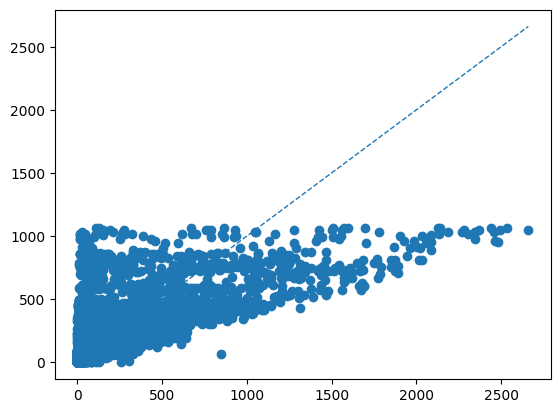

In [98]:
ground_predicted(model)

In [244]:
import matplotlib.pyplot as plt
def ground_predicted(mdl, desc=''):
    y_hat = mdl.predict(X_test)

    #fig, ax = plt.subplots()

    #plt.figure(figsize=(20, 20))
    
    plt.scatter(y_test, y_hat)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=1)
    
    #ax.set_xlabel('Actual (Ground Truth)')
    #ax.set_ylabel('Predicted')
    #ax.set_title(f"Ground Truth vs Predicted | {desc}")

## XGBoost

In [301]:
df_train

,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year,station_complex_id_10,station_complex_id_103,station_complex_id_109,fare_class_category_Metrocard - Fair Fare,...,fare_class_category_Metrocard - Students,fare_class_category_Metrocard - Unlimited 30-Day,fare_class_category_Metrocard - Unlimited 7-Day,fare_class_category_OMNY - Fair Fare,fare_class_category_OMNY - Full Fare,fare_class_category_OMNY - Other,fare_class_category_OMNY - Seniors & Disability,fare_class_category_OMNY - Students,borough_Manhattan,borough_Queens
32996,14,4,6,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32997,53,4,10,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32998,16,4,12,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32999,75,4,11,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
33000,410,4,23,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708830,2,6,5,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708831,21,6,14,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708832,2,6,0,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
708833,4,6,13,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [302]:
from xgboost import XGBRegressor

In [303]:
model = XGBRegressor(n_estimators=1500, early_stopping_rounds=50, max_depth=7, learning_rate=0.01)

In [304]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[0]	validation_0-rmse:96.16828	validation_1-rmse:134.75885
[10]	validation_0-rmse:88.14187	validation_1-rmse:125.76687
[20]	validation_0-rmse:80.97987	validation_1-rmse:117.77538
[30]	validation_0-rmse:74.56486	validation_1-rmse:110.58932
[40]	validation_0-rmse:68.84661	validation_1-rmse:104.23504
[50]	validation_0-rmse:63.74817	validation_1-rmse:98.59552
[60]	validation_0-rmse:59.17961	validation_1-rmse:93.54366
[70]	validation_0-rmse:55.11033	validation_1-rmse:89.16808
[80]	validation_0-rmse:51.49160	validation_1-rmse:85.34301
[90]	validation_0-rmse:48.25692	validation_1-rmse:81.93379
[100]	validation_0-rmse:45.42301	validation_1-rmse:79.01134
[110]	validation_0-rmse:42.87165	validation_1-rmse:76.29926
[120]	validation_0-rmse:40.55949	validation_1-rmse:73.80571
[130]	validation_0-rmse:38.55173	validation_1-rmse:71.58938
[140]	validation_0-rmse:36.78001	validation_1-rmse:69.60080
[150]	validation_0-rmse:35.18243	validation_1-rmse:67.72077
[160]	validation_0-rmse:33.74697	validation_1-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [305]:
pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_)

,0
day_of_week,0.037638
hour_of_day,0.121430
month_of_year,0.019128
day_of_month,0.003002
year,0.071224
station_complex_id_10,0.205094
station_complex_id_103,0.016332
station_complex_id_109,0.002999
fare_class_category_Metrocard - Fair Fare,0.002552
fare_class_category_Metrocard - Full Fare,0.136414


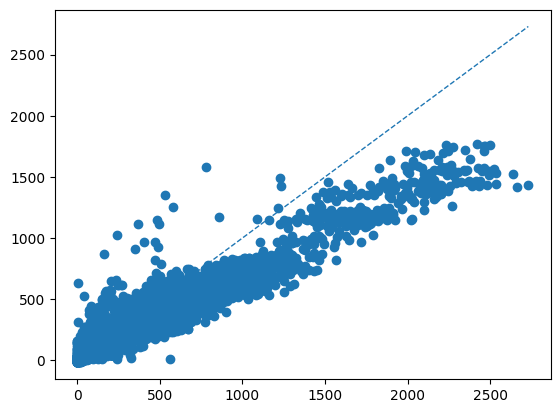

In [306]:
ground_predicted(model)

In [307]:
preds = model.predict(X_test)

In [308]:
from sklearn.metrics import r2_score

In [309]:
r2_score(y_test, preds)

0.8794282078742981

In [345]:
tplot = df_test.copy()

In [347]:
df_train.head()

,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year,station_complex_id_10,station_complex_id_103,station_complex_id_109,fare_class_category_Metrocard - Fair Fare,...,fare_class_category_Metrocard - Students,fare_class_category_Metrocard - Unlimited 30-Day,fare_class_category_Metrocard - Unlimited 7-Day,fare_class_category_OMNY - Fair Fare,fare_class_category_OMNY - Full Fare,fare_class_category_OMNY - Other,fare_class_category_OMNY - Seniors & Disability,fare_class_category_OMNY - Students,borough_Manhattan,borough_Queens
32996,14,4,6,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32997,53,4,10,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32998,16,4,12,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32999,75,4,11,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
33000,410,4,23,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [349]:
tplot.head()

,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year,station_complex_id_10,station_complex_id_103,station_complex_id_109,fare_class_category_Metrocard - Fair Fare,...,fare_class_category_Metrocard - Students,fare_class_category_Metrocard - Unlimited 30-Day,fare_class_category_Metrocard - Unlimited 7-Day,fare_class_category_OMNY - Fair Fare,fare_class_category_OMNY - Full Fare,fare_class_category_OMNY - Other,fare_class_category_OMNY - Seniors & Disability,fare_class_category_OMNY - Students,borough_Manhattan,borough_Queens
0,3,4,16,10,18,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,4,23,10,18,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,1,14,10,22,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,9,3,11,10,17,2024,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,3,5,10,17,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [352]:
def predict(r):
    print(r)
    return model.predict(r[['day_of_week', 'hour_of_day', 'month_of_year', 'day_of_month', 'year', 'station_complex_id_10', 'station_complex_id_103', 'station_complex_id_109', 'fare_class_category_Metrocard - Fair Fare', 'fare_class_category_Metrocard - Full Fare', 'fare_class_category_Metrocard - Other', 'fare_class_category_Metrocard - Seniors & Disability', 'fare_class_category_Metrocard - Students', 'fare_class_category_Metrocard - Unlimited 30-Day', 'fare_class_category_Metrocard - Unlimited 7-Day', 'fare_class_category_OMNY - Fair Fare', 'fare_class_category_OMNY - Full Fare', 'fare_class_category_OMNY - Other', 'fare_class_category_OMNY - Seniors & Disability', 'fare_class_category_OMNY - Students', 'borough_Manhattan', 'borough_Queens']])

In [353]:
tplot['predicted'] = tplot.apply(predict, axis=1)

ridership                                                  3.0
day_of_week                                                4.0
hour_of_day                                               16.0
month_of_year                                             10.0
day_of_month                                              18.0
year                                                    2024.0
station_complex_id_10                                      1.0
station_complex_id_103                                     0.0
station_complex_id_109                                     0.0
fare_class_category_Metrocard - Fair Fare                  0.0
fare_class_category_Metrocard - Full Fare                  0.0
fare_class_category_Metrocard - Other                      0.0
fare_class_category_Metrocard - Seniors & Disability       0.0
fare_class_category_Metrocard - Students                   0.0
fare_class_category_Metrocard - Unlimited 30-Day           0.0
fare_class_category_Metrocard - Unlimited 7-Day        

ValueError: feature_names mismatch: ['day_of_week', 'hour_of_day', 'month_of_year', 'day_of_month', 'year', 'station_complex_id_10', 'station_complex_id_103', 'station_complex_id_109', 'fare_class_category_Metrocard - Fair Fare', 'fare_class_category_Metrocard - Full Fare', 'fare_class_category_Metrocard - Other', 'fare_class_category_Metrocard - Seniors & Disability', 'fare_class_category_Metrocard - Students', 'fare_class_category_Metrocard - Unlimited 30-Day', 'fare_class_category_Metrocard - Unlimited 7-Day', 'fare_class_category_OMNY - Fair Fare', 'fare_class_category_OMNY - Full Fare', 'fare_class_category_OMNY - Other', 'fare_class_category_OMNY - Seniors & Disability', 'fare_class_category_OMNY - Students', 'borough_Manhattan', 'borough_Queens'] ['0']
expected fare_class_category_OMNY - Other, fare_class_category_Metrocard - Unlimited 30-Day, fare_class_category_OMNY - Seniors & Disability, station_complex_id_103, fare_class_category_Metrocard - Full Fare, year, fare_class_category_Metrocard - Seniors & Disability, fare_class_category_OMNY - Fair Fare, hour_of_day, fare_class_category_OMNY - Full Fare, day_of_week, borough_Queens, month_of_year, fare_class_category_Metrocard - Fair Fare, fare_class_category_Metrocard - Other, day_of_month, station_complex_id_10, fare_class_category_OMNY - Students, fare_class_category_Metrocard - Students, fare_class_category_Metrocard - Unlimited 7-Day, borough_Manhattan, station_complex_id_109 in input data
training data did not have the following fields: 0

In [314]:
tplot['month'] = tplot['month_of_year']
tplot['day'] = tplot['day_of_month']
tplot['hour'] = tplot['hour_of_day']

tplot['timestamp'] = pd.to_datetime(tplot[['year', 'month', 'day', 'hour']])

In [321]:
tplot = tplot.set_index('timestamp')

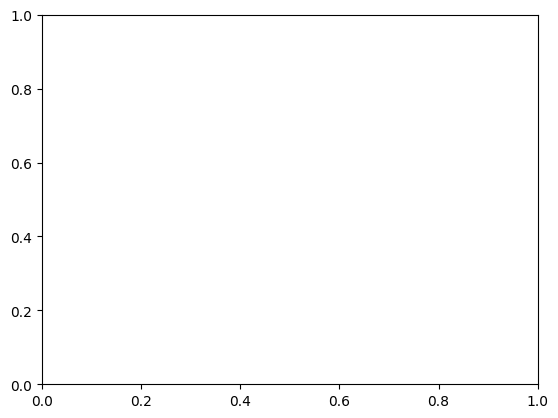

In [337]:
fig, ax = plt.subplots()

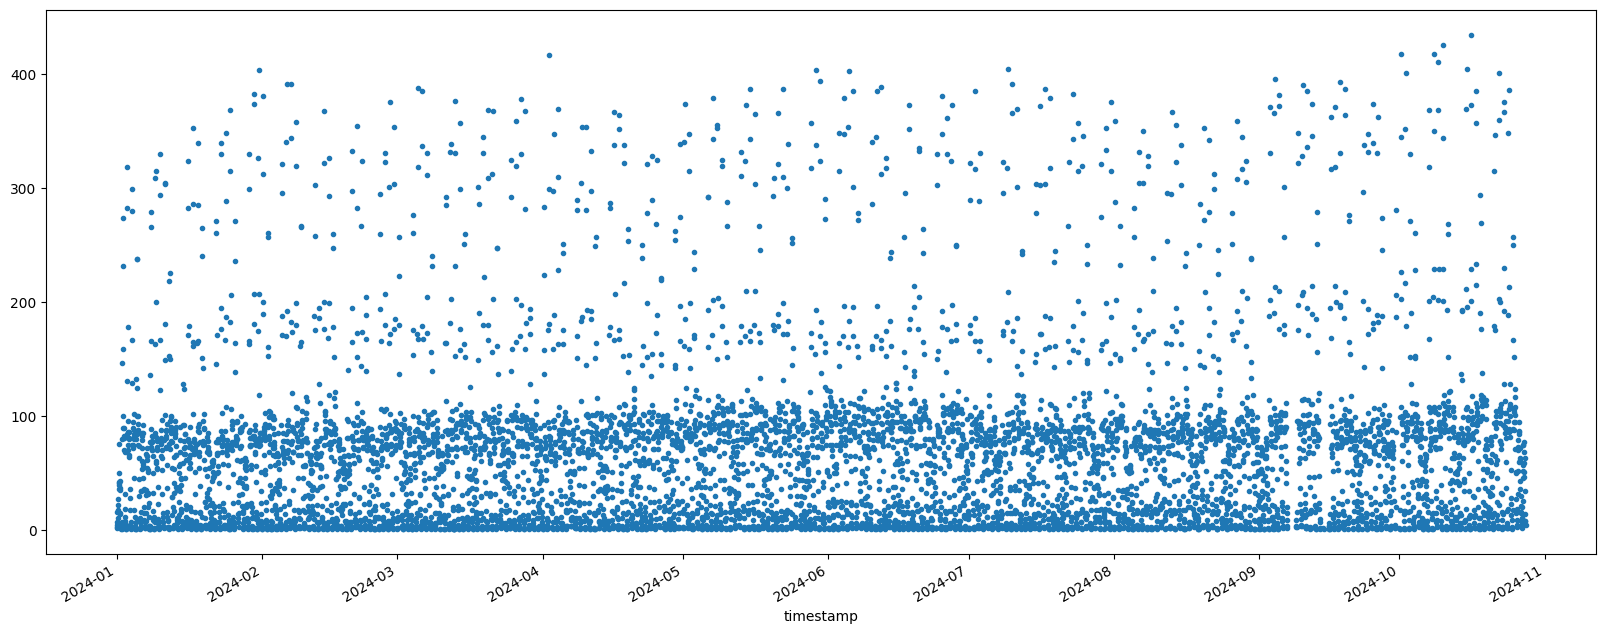

In [341]:
ax = tplot[(tplot['fare_class_category_OMNY - Full Fare'] == 1.0) & (tplot['station_complex_id_109'] == 1.0)]['ridership'].plot(style='.',figsize=(20,8))

In [344]:
tplot['predicted'] = tplot.apply(model.predict, axis=1)


ValueError: feature_names mismatch: ['day_of_week', 'hour_of_day', 'month_of_year', 'day_of_month', 'year', 'station_complex_id_10', 'station_complex_id_103', 'station_complex_id_109', 'fare_class_category_Metrocard - Fair Fare', 'fare_class_category_Metrocard - Full Fare', 'fare_class_category_Metrocard - Other', 'fare_class_category_Metrocard - Seniors & Disability', 'fare_class_category_Metrocard - Students', 'fare_class_category_Metrocard - Unlimited 30-Day', 'fare_class_category_Metrocard - Unlimited 7-Day', 'fare_class_category_OMNY - Fair Fare', 'fare_class_category_OMNY - Full Fare', 'fare_class_category_OMNY - Other', 'fare_class_category_OMNY - Seniors & Disability', 'fare_class_category_OMNY - Students', 'borough_Manhattan', 'borough_Queens'] ['2024-10-18 16:00:00']
expected fare_class_category_OMNY - Other, fare_class_category_Metrocard - Unlimited 30-Day, fare_class_category_OMNY - Seniors & Disability, station_complex_id_103, fare_class_category_Metrocard - Full Fare, year, fare_class_category_Metrocard - Seniors & Disability, fare_class_category_OMNY - Fair Fare, hour_of_day, fare_class_category_OMNY - Full Fare, day_of_week, borough_Queens, month_of_year, fare_class_category_Metrocard - Fair Fare, fare_class_category_Metrocard - Other, day_of_month, station_complex_id_10, fare_class_category_OMNY - Students, fare_class_category_Metrocard - Students, fare_class_category_Metrocard - Unlimited 7-Day, borough_Manhattan, station_complex_id_109 in input data
training data did not have the following fields: 2024-10-18 16:00:00

In [243]:
for idx in range(len(y_test)):
    if abs(y_test.iloc[idx] - preds[idx]) > 500:
        print(X_test.iloc[idx][['day_of_week', 'hour_of_day']])
        print('---')
        print(y_test.iloc[idx], preds[idx])
        print()

day_of_week     2.0
hour_of_day    16.0
Name: 55, dtype: float64
---
1305 388.28867

day_of_week     2.0
hour_of_day    18.0
Name: 77, dtype: float64
---
1914 625.7296

day_of_week     3.0
hour_of_day    18.0
Name: 167, dtype: float64
---
1673 615.0145

day_of_week     3.0
hour_of_day    17.0
Name: 181, dtype: float64
---
2204 683.2362

day_of_week     3.0
hour_of_day    19.0
Name: 243, dtype: float64
---
876 363.01404

day_of_week     3.0
hour_of_day    16.0
Name: 311, dtype: float64
---
994 390.51794

day_of_week     1.0
hour_of_day    21.0
Name: 343, dtype: float64
---
1022 413.4264

day_of_week     1.0
hour_of_day    16.0
Name: 371, dtype: float64
---
942 429.63916

day_of_week     1.0
hour_of_day    17.0
Name: 426, dtype: float64
---
2282 791.49854

day_of_week     1.0
hour_of_day    19.0
Name: 446, dtype: float64
---
923 411.07242

day_of_week     3.0
hour_of_day    22.0
Name: 491, dtype: float64
---
902 363.98154

day_of_week     3.0
hour_of_day    21.0
Name: 498, dtype: float64